In [1]:
import pandas as pd
data = pd.read_csv('D:/혁신성장/final.csv',encoding='cp949')
data1 = pd.read_csv('D:/혁신성장/서울시군구좌표.csv',encoding='cp949')

In [2]:
data_category_temperature = pd.merge(data,data1,how = 'left',left_on="자치구", right_on="시군구명").drop("평균기온(°C)",axis=1)
data_numeric_temperature = pd.merge(data,data1,how = 'left',left_on="자치구", right_on="시군구명").drop("평균기온 범주화",axis=1)


In [3]:
import os
import tarfile
import urllib
import sys
assert sys.version_info >= (3,5)
import sklearn
assert sklearn.__version__>="0.20"
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png",resolution=300):
    path=os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


In [5]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

### 한글폰트설정

In [6]:
# 폰트 설정 방법 1
import matplotlib.pyplot as plt

# matplotlib 폰트설정
# plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rc('font', family='NanumGothic') # For Windows
print(plt.rcParams['font.family'])

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

['NanumGothic']


array([[<AxesSubplot:title={'center':'이동거리(M)'}>,
        <AxesSubplot:title={'center':'이용건수'}>,
        <AxesSubplot:title={'center':'이용시간(분)'}>,
        <AxesSubplot:title={'center':'평균기온(°C)'}>],
       [<AxesSubplot:title={'center':'최고기온(°C)'}>,
        <AxesSubplot:title={'center':'일강수량(mm)'}>,
        <AxesSubplot:title={'center':'최대 풍속(m/s)'}>,
        <AxesSubplot:title={'center':'평균 상대습도(%)'}>],
       [<AxesSubplot:title={'center':'PM10(미세먼지)'}>,
        <AxesSubplot:title={'center':'PM2.5(초미세먼지)'}>,
        <AxesSubplot:title={'center':'월'}>,
        <AxesSubplot:title={'center':'주말'}>],
       [<AxesSubplot:title={'center':'거리두기단계'}>,
        <AxesSubplot:title={'center':'인구수'}>,
        <AxesSubplot:title={'center':'위도'}>,
        <AxesSubplot:title={'center':'경도'}>]], dtype=object)

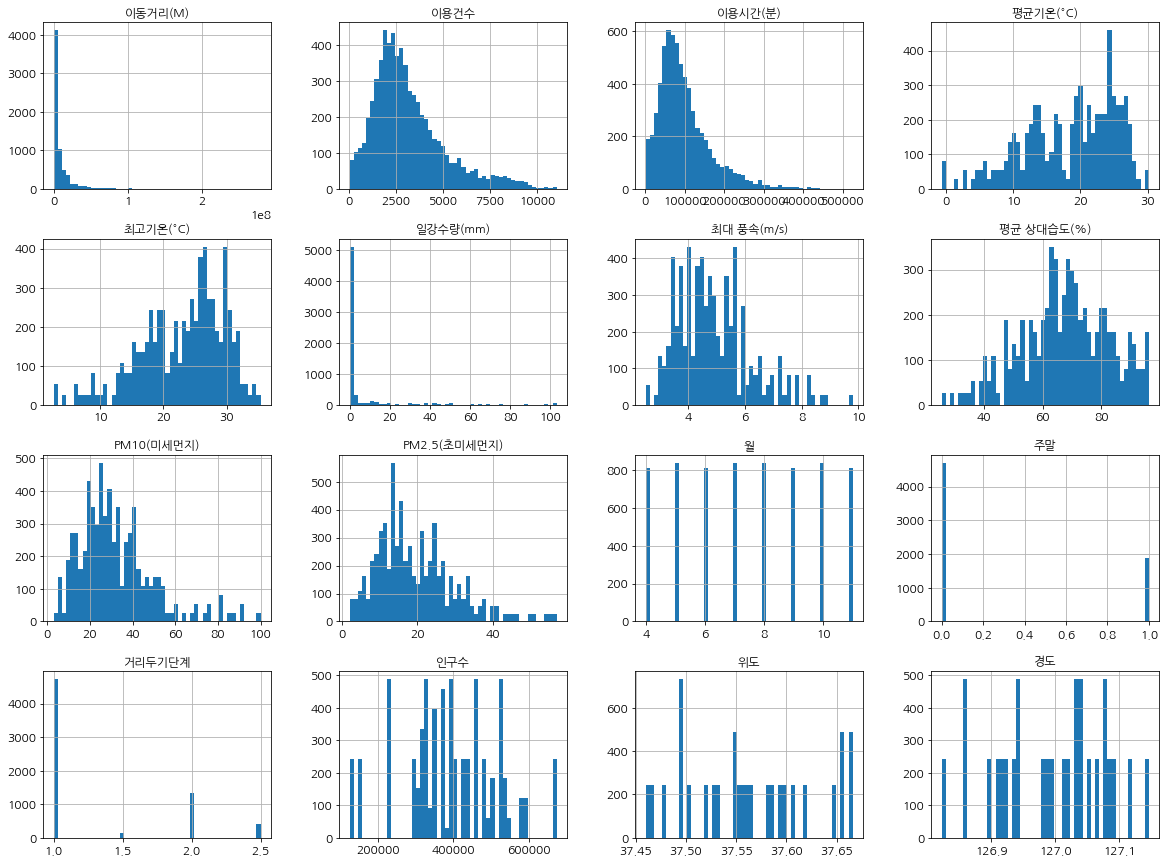

In [7]:
data_numeric_temperature = data_numeric_temperature.drop("Unnamed: 0", axis=1)
data_numeric_temperature.hist(bins=50, figsize=(20,15))

In [8]:
def change_type(data):
    data["월"] = data["월"].astype(object)
    data["주말"] = data["주말"].astype(object)
    data["거리두기단계"] = data["거리두기단계"].astype(object)

change_type(data_numeric_temperature)

In [9]:
final_data = data_numeric_temperature.drop(["자치구","대여일자","시군구명","이동거리(M)","이용시간(분)","지역구"],axis=1)

In [10]:
final_data.columns

Index(['이용건수', '평균기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 풍속(m/s)', '평균 상대습도(%)',
       'PM10(미세먼지)', 'PM2.5(초미세먼지)', '월', '주말', '거리두기단계', '인구수', '위도', '경도'],
      dtype='object')

### 데이터셋 분할

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(final_data,final_data["주말"]):
    strat_train_set = final_data.loc[train_index]
    strat_test_set = final_data.loc[test_index]
print(strat_test_set["주말"].value_counts()/len(strat_test_set))
print(final_data["주말"].value_counts()/len(final_data))

0    0.713202
1    0.286798
Name: 주말, dtype: float64
0    0.713115
1    0.286885
Name: 주말, dtype: float64


### 라벨값 분리

In [12]:
data_x = strat_train_set.drop("이용건수",axis=1)
data_y = strat_train_set["이용건수"].copy()

### 결측값 확인

In [13]:
data_x.isnull().sum()

평균기온(°C)         0
최고기온(°C)         0
일강수량(mm)         0
최대 풍속(m/s)       0
평균 상대습도(%)       0
PM10(미세먼지)      21
PM2.5(초미세먼지)    21
월                0
주말               0
거리두기단계           0
인구수              0
위도               0
경도               0
dtype: int64

### 파이프라인

In [14]:
num_attribs = list(data_x.drop(["월","주말","거리두기단계"],axis=1))
cat_attribs = ["월","주말","거리두기단계"]

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
data_prepared = full_pipeline.fit_transform(data_x)
print(data_prepared)
print(data.shape)

[[-1.24626862 -1.04897413 -0.35731448 ...  0.          0.
   0.        ]
 [-1.3197493  -1.3214066  -0.35731448 ...  0.          0.
   0.        ]
 [ 0.25273729  0.0256206   3.43214951 ...  0.          0.
   0.        ]
 ...
 [ 0.10577593  0.29805307 -0.35731448 ...  0.          0.
   0.        ]
 [-0.86416907 -1.13978495  0.02338901 ...  0.          0.
   0.        ]
 [-0.14405839  0.1467017  -0.35731448 ...  0.          0.
   0.        ]]
(6588, 19)


### 리니어 레그리션

In [17]:
from sklearn.linear_model  import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(data_prepared, data_y)

LinearRegression()

In [18]:
some_data = data_x.iloc[:5]
some_labels = data_y.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("예측: ", lin_reg.predict(some_data_prepared))

예측:  [3533.74811096 4016.44319875 2109.43898105 3048.9738155  4214.76254908]


In [19]:
print("레이블:", list(some_labels))

레이블: [2427, 2360, 1297, 3682, 5492]


In [20]:
##data_prepared

In [21]:
from sklearn.metrics import mean_squared_error

data_predictions = lin_reg.predict(data_prepared)
len(data_predictions)
lin_mse = mean_squared_error(data_y, data_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1445.2039037832546

<AxesSubplot:>

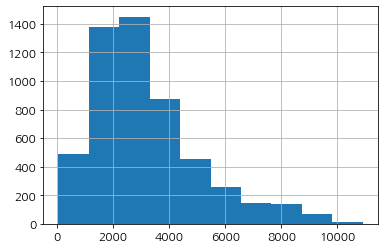

In [22]:
data_y.hist()

### 의사결정나무

In [23]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=23,random_state=42)
tree_reg.fit(data_prepared, data_y)

DecisionTreeRegressor(max_depth=23, random_state=42)

In [24]:
from sklearn.metrics import mean_squared_error

data_predictions = tree_reg.predict(data_prepared)
tree_mse = mean_squared_error(data_y, data_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_mse

241.44201011670174

In [25]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, data_prepared, data_y, scoring = "neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [26]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())
    
display_scores(tree_rmse_scores)

점수: [578.53782224 566.70496468 639.45058439 559.49786802 564.64506529
 577.89633295 591.71314567 719.71093283 659.32147602 563.32317428]
평균: 602.0801366364819
표준 편차: 50.71965696965644


In [27]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(data_prepared, data_y)

RandomForestRegressor(random_state=42)

In [28]:
data_predictions = forest_reg.predict(data_prepared)
forest_mse = mean_squared_error(data_y, data_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

162.94928541846107

In [29]:
rf_model2 = forest_reg

X_test2 = strat_test_set.drop("이용건수", axis=1)
y_test2 = strat_test_set["이용건수"].copy()


X_test_prepared2 = full_pipeline.transform(X_test2)
rf_model2.fit(X_test_prepared2, y_test2)
rf_predictions =rf_model2.predict(X_test_prepared2)

rf_mse = mean_squared_error(y_test2, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

211.6992914274757

### 크로스발리데이션

In [30]:
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(forest_reg, data_prepared, data_y, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [382.08852462 415.40451439 475.59311025 488.69681817 416.14576258
 401.20726168 432.78061828 544.89662639 478.12460272 459.01769469]
평균: 449.3955533768875
표준 편차: 46.53884741956707


In [31]:
data_prepared

array([[-1.24626862, -1.04897413, -0.35731448, ...,  0.        ,
         0.        ,  0.        ],
       [-1.3197493 , -1.3214066 , -0.35731448, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25273729,  0.0256206 ,  3.43214951, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.10577593,  0.29805307, -0.35731448, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86416907, -1.13978495,  0.02338901, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14405839,  0.1467017 , -0.35731448, ...,  0.        ,
         0.        ,  0.        ]])

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid= [
    #12(=3*4)개의 하이퍼파라미터 조합을 시도합니다. #n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]
    {'n_estimators': [10, 30, 60, 90], 'max_features': [2, 4, 6, 8]},  # n_estimators:  랜덤 포레스트가 생성하는 디시전트리의 갯수  
    #bootstrap은 False로 하고 6(=2*3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [30, 60], 'max_features': [2, 3, 4, 6]}
]

forest_reg = RandomForestRegressor(random_state=42)
#다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(data_prepared, data_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [10, 30, 60, 90]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4, 6],
                          'n_estimators': [30, 60]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [33]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'bootstrap': False, 'max_features': 6, 'n_estimators': 60}
RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=60,
                      random_state=42)


In [34]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.068643,0.015512,0.005325,0.005718,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-704517.236575,-632317.863112,...,-657423.066649,41349.911308,24,-158517.559056,-132376.561072,-129803.814009,-131158.642659,-137226.976262,-137816.710611,10648.986062
1,0.253420,0.067721,0.015922,0.004525,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-577225.520294,-637952.579805,...,-615184.873527,27710.359231,22,-106851.457800,-106269.126378,-100666.918116,-101188.268277,-100897.611061,-103174.676326,2775.393216
2,0.604772,0.056645,0.028315,0.011554,2,60,NaN,"{'max_features': 2, 'n_estimators': 60}",-559957.954799,-629502.613144,...,-592854.034235,31839.810404,21,-95663.082172,-94175.229747,-85900.283664,-91529.875738,-83929.720511,-90239.638366,4587.208242
3,0.540341,0.013617,0.030308,0.001651,2,90,NaN,"{'max_features': 2, 'n_estimators': 90}",-564428.160742,-611002.406534,...,-592458.663515,22221.478960,20,-90461.403443,-88749.246977,-85435.880050,-88381.654620,-83031.579262,-87211.952871,2642.739584
4,0.076307,0.004745,0.003232,0.003748,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-238429.775854,-319421.870911,...,-284686.748911,31564.458779,16,-58427.574428,-60514.187457,-63805.268323,-63619.543703,-74143.544798,-64102.023742,5407.863536
5,0.228063,0.013645,0.010594,0.000800,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-206469.243345,-294964.167439,...,-245671.783297,29898.601626,15,-41583.761566,-47070.913147,-43085.287172,-41124.746275,-45169.727372,-43606.887106,2234.639687
6,0.451519,0.009922,0.018989,0.001549,4,60,NaN,"{'max_features': 4, 'n_estimators': 60}",-211806.445857,-265092.418437,...,-238782.055371,20630.813410,14,-38130.878415,-37388.221482,-37373.469153,-35445.461715,-37061.391500,-37079.884453,889.666419
7,0.657992,0.011334,0.027784,0.000400,4,90,NaN,"{'max_features': 4, 'n_estimators': 90}",-202104.691168,-258114.523901,...,-230821.085207,23609.526883,13,-34670.245594,-34508.247672,-34330.977065,-32371.231747,-34536.414280,-34083.423271,862.892781
8,0.091743,0.000979,0.004198,0.000400,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-184482.657192,-269045.539336,...,-225174.799896,28903.198715,12,-43514.425337,-43025.143653,-44619.079046,-44137.415761,-44360.599435,-43931.332647,582.189923
9,0.279626,0.016788,0.010194,0.000400,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-157709.641252,-236781.239670,...,-193963.012145,31301.207994,8,-30294.463875,-29569.133287,-30549.460444,-31310.783231,-30591.132241,-30462.994616,560.362706


In [35]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

810.816296487038 {'max_features': 2, 'n_estimators': 10}
784.3372192667466 {'max_features': 2, 'n_estimators': 30}
769.9701515221079 {'max_features': 2, 'n_estimators': 60}
769.7133645164231 {'max_features': 2, 'n_estimators': 90}
533.5604454144028 {'max_features': 4, 'n_estimators': 10}
495.6528858956111 {'max_features': 4, 'n_estimators': 30}
488.65330795077125 {'max_features': 4, 'n_estimators': 60}
480.4384301931967 {'max_features': 4, 'n_estimators': 90}
474.5258685210277 {'max_features': 6, 'n_estimators': 10}
440.41232060996646 {'max_features': 6, 'n_estimators': 30}
421.59914738804434 {'max_features': 6, 'n_estimators': 60}
419.3483120830011 {'max_features': 6, 'n_estimators': 90}
462.9724780816896 {'max_features': 8, 'n_estimators': 10}
429.7007507987167 {'max_features': 8, 'n_estimators': 30}
421.1837536276684 {'max_features': 8, 'n_estimators': 60}
419.22993777348546 {'max_features': 8, 'n_estimators': 90}
789.1620087045536 {'bootstrap': False, 'max_features': 2, 'n_estimato

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=24),
}
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(data_prepared, data_y)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000246C9AFEA48>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000246D01E6B08>},
                   random_state=42, scoring='neg_mean_squared_error')

In [37]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

411.1721468723505 {'max_features': 7, 'n_estimators': 180}
441.7052618883723 {'max_features': 15, 'n_estimators': 107}
415.8687467363055 {'max_features': 8, 'n_estimators': 189}
456.15612623198706 {'max_features': 21, 'n_estimators': 103}
450.95289703887545 {'max_features': 19, 'n_estimators': 75}
427.6125228682938 {'max_features': 11, 'n_estimators': 88}
456.537848204222 {'max_features': 21, 'n_estimators': 100}
416.00290426911107 {'max_features': 8, 'n_estimators': 152}
579.8087142350304 {'max_features': 3, 'n_estimators': 150}
581.7658045367339 {'max_features': 21, 'n_estimators': 2}


In [38]:
print(rnd_search.best_params_)
print(rnd_search.best_estimator_)

{'max_features': 7, 'n_estimators': 180}
RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)


In [39]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.03389762, 0.03862501, 0.12357883, 0.01751088, 0.06890194,
       0.01232161, 0.01040606, 0.32450519, 0.12745869, 0.19924724,
       0.00369789, 0.00213038, 0.00237232, 0.00163027, 0.00865566,
       0.00619794, 0.00218986, 0.00350559, 0.00301942, 0.00306885,
       0.00304571, 0.00034777, 0.00228724, 0.00139803])

In [40]:
len(data_y)

5270

In [41]:
len(data_numeric_temperature) 

6588

In [42]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("이용건수", axis=1)
y_test = strat_test_set["이용건수"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions =final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

390.1305828916041

<AxesSubplot:>

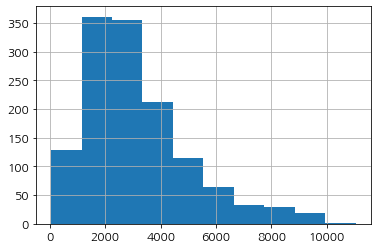

In [43]:
y_test.hist()

In [45]:
final_model3 = grid_search.best_estimator_

X_test3 = strat_test_set.drop("이용건수", axis=1)
y_test3 = strat_test_set["이용건수"].copy()

X_test_prepared3 = full_pipeline.transform(X_test3)
final_predictions3 =final_model3.predict(X_test_prepared3)

final_mse3 = mean_squared_error(y_test3, final_predictions3)
final_rmse3 = np.sqrt(final_mse3)
final_rmse3

383.5659134445918